# Protein folding 
Using our implementation of the AMBER forcefield for protein folding. 
Currently, it lacks water. 


## Todo 
1. GNN sims
2. CG sims
3. add water 

In [1]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-1 # 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [2]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [4]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [5]:
# import time
# import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
# import torch.nn.functional as F

# import openmm as omm
from openmm import app, unit


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.energy import Energy, EnergyModule, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

### protein folding module
import proteinfolding as pf

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

## Annealer module

In [6]:
# Define an annealing scheduler
from torch.optim.lr_scheduler import ExponentialLR

class AnnealingLR(ExponentialLR):
    def __init__(self, optimizer, lr_min, lr_max, epochs, last_epoch=-1):
        self.epochs = epochs
        self.epoch_counter = 0 # we use this to know when to stop decaying the LR
        self.get_decay_rate(lr_min, lr_max, epochs)
        super(AnnealingLR, self).__init__(optimizer, self.gamma, last_epoch)
    
    def get_decay_rate(self, lr_min, lr_max, epochs):
        self.gamma = (lr_min/lr_max)**(1/epochs)
    
    # we can redefine step to change the learning rate only before "epochs" epochs
    def step(self):
        if self.epoch_counter < self.epochs:
            self.epoch_counter += 1
            super(AnnealingLR, self).step()
        else:
            pass

# Loading protein

In [7]:
# pdb_id = '2WXC' # '2JOF' # '5AWL'
pdb_id = '2JOF'

pdb_dir = '../data/pdb/'
os.makedirs(pdb_dir, exist_ok=True) 

pdb_file = os.path.join(pdb_dir, pdb_id+'.pdb')

# check if pdb file exists, if not download it
if not os.path.isfile(pdb_file):
    pdb_file = pf.download_pdb_file(pdb_id, dir = pdb_dir)
    
prot = pf.Protein(pdb_file)


In [8]:
pdb = app.PDBFile(pdb_file)
modeller = app.Modeller(pdb.topology, pdb.positions)
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
#self.modeller.deleteWater()
# modeller.addSolvent(forcefield, model="tip3p", padding=.05 * unit.nanometer)
system = forcefield.createSystem(modeller.topology)#, nonbondedMethod=PME, constraints=HBonds)


In [9]:
system.getNumParticles(), system.getNumForces()

(284, 5)

In [10]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = prot.node_positions.detach().numpy()*10 # 10x to go from nm to angstrom

pdb_orig_file = os.path.join(pdb_dir, f'orig-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_orig_file , 'w'))

In [11]:
import py3Dmol

# let's pick the pdb id of a small protein with two alpha helices:
# pdb_id = '2JOF' #  '1HLO'
# pdb_dir = '../data/pdb/'
# os.makedirs(pdb_dir, exist_ok=True) 
# pf.download_pdb_file(pdb_id, dir = pdb_dir)
# pdb_test_file = os.path.join(pdb_dir, pdb_id+'.pdb')

p_ = py3Dmol.view(data=pf.get_file_text(pdb_orig_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# p_.addModel(pf.get_file_text(pdb_file), 'pdb')
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'


In [12]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Energy Minimization

In [14]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
pdb_energy

99245.3828125

## Starting from PDB positions

In [24]:
# define the initial position
initial_pos = x = prot.node_positions.to(DEVICE)

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [25]:
h = energy_minimizer.train(10000)

Early stopping at step 3820


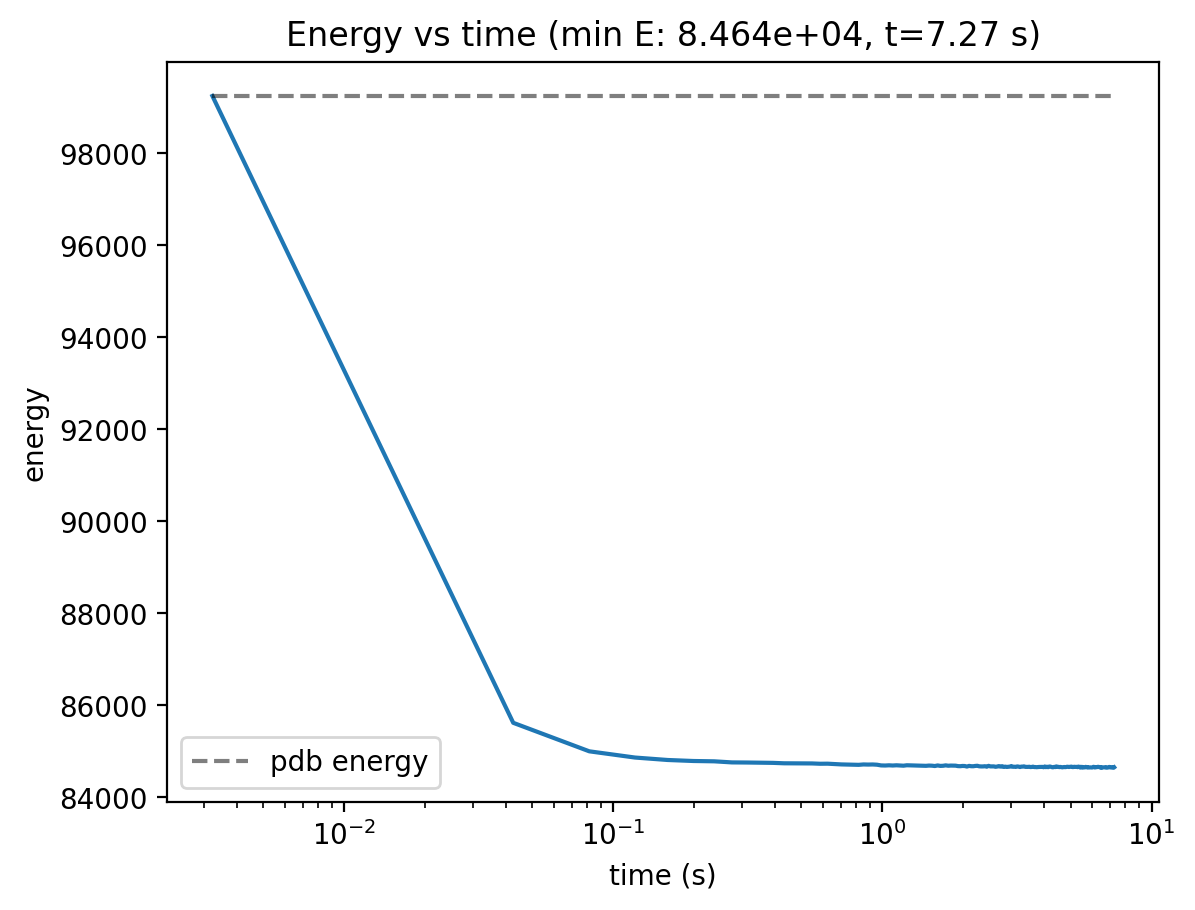

In [26]:
energy_minimizer.plot_history()
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

In [27]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.4871, 0.4551, 0.3484], device='cuda:0', grad_fn=<StdBackward0>)

In [28]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./PDB_refine-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [29]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [30]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 1.0950926358874051, 'CA': 0.8053816838948542, 'backbone': 0.7841616120611717}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Starting from Random Init

In [ ]:
r0 = 0.15 # nm
v0 = 4/3*np.pi*r0**3
# total volume occupied by all atoms
vn = len(prot.node_positions)*v0
init_radius = (vn*3/4/np.pi)**(1/3)
init_radius


In [578]:
# define the initial position
x = torch.randn_like(prot.node_positions)
# scale x to have std = s*std of original positions
# x = x * 1.5 * prot.node_positions.std(dim=0)
x = .1 * x * init_radius
x = x.to(DEVICE)
initial_pos = x

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR*1e-1, #1e-1, 
                                clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', 
                            patience=PATIENCE, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [579]:
energy_minimizer.min_delta

0.1

In [580]:
N = 100
drop_rate = 40 #10
annealer = AnnealingLR(energy_minimizer.optimizer, 
                    lr_max=energy_minimizer.lr, 
                    lr_min=energy_minimizer.lr/drop_rate, 
                    epochs=N)


In [581]:
annealer.gamma

0.9637833073548235

In [582]:
relax_counter = 10
for epoch in range(2*N):
    h = energy_minimizer.train(500)
    # also print the current lr
    if np.isnan(h['energy'][-1]):
        print('============Fail! nan')
        break
    c = energy_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    annealer.step()
    print(f'FG lr: {annealer.get_last_lr()[0]:.2e}', end = '\r')

    if energy_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 400, time: 91.95 s, pat:4, FG lr: 1.12e-0504
epoch: 97, energy: 84588, time: 92.73 s, pat:20, FG lr: 1.08e-05
relaxing 9
Early stopping at step 400
epoch: 98, energy: 84588, time: 93.50 s, pat:20, FG lr: 1.04e-05
relaxing 8
Early stopping at step 400
epoch: 99, energy: 84588, time: 94.28 s, pat:20, FG lr: 1.04e-05
relaxing 7
Early stopping at step 400
epoch: 100, energy: 84587.9, time: 95.06 s, pat:20, FG lr: 1.04e-05
relaxing 6
Early stopping at step 400
epoch: 101, energy: 84587.9, time: 95.85 s, pat:20, FG lr: 1.04e-05
relaxing 5
Early stopping at step 400
epoch: 102, energy: 84587.9, time: 96.63 s, pat:20, FG lr: 1.04e-05
relaxing 4
Early stopping at step 400
epoch: 103, energy: 84587.9, time: 97.40 s, pat:20, FG lr: 1.04e-05
relaxing 3
Early stopping at step 400
epoch: 104, energy: 84587.9, time: 98.18 s, pat:20, FG lr: 1.04e-05
relaxing 2
Early stopping at step 400
epoch: 105, energy: 84587.9, time: 98.96 s, pat:20, FG lr: 1.04e-05
relaxing 1
Early stopping

In [374]:
h = energy_minimizer.train(20000)

Early stopping at step 400


Text(0.5, 1.0, 'Energy vs time (min E: 8.459e+04, t=100.53 s)')

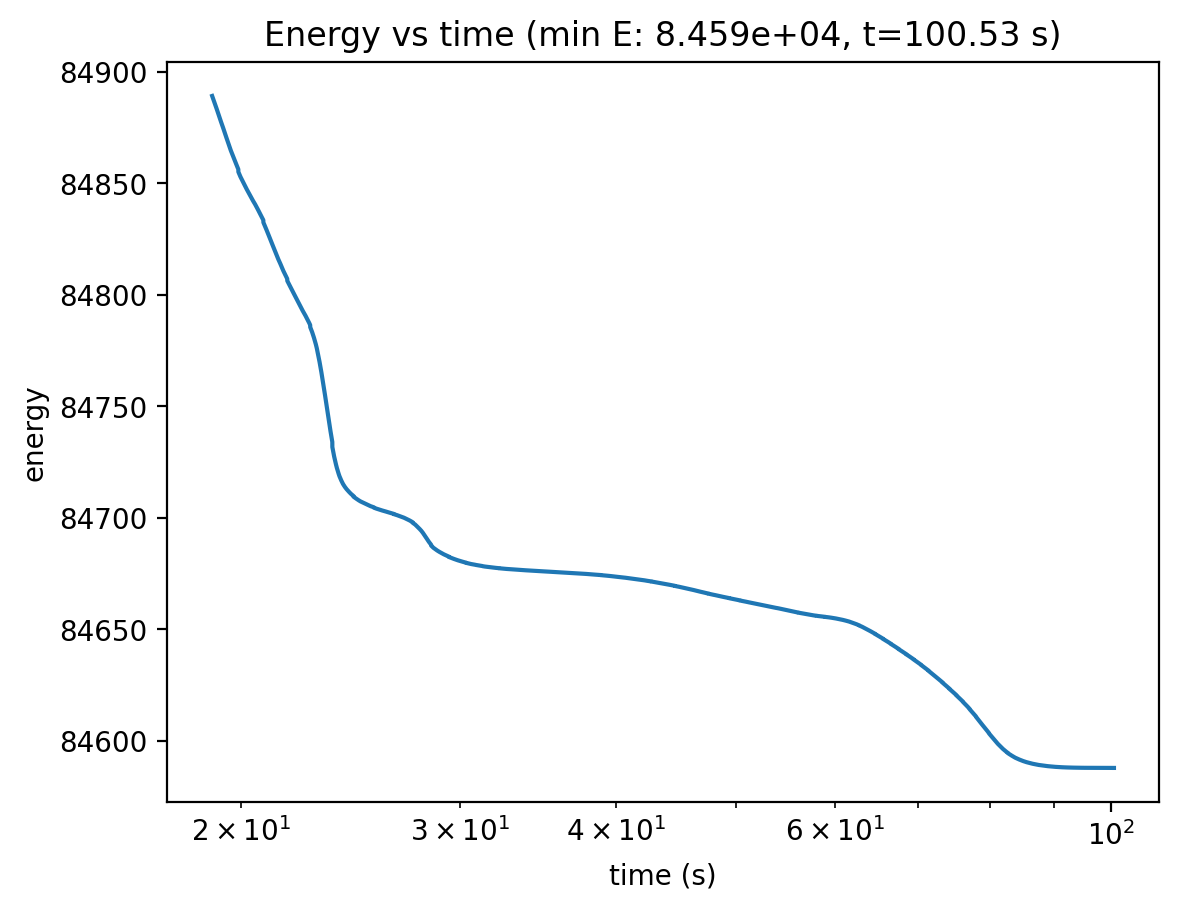

In [583]:
h = energy_minimizer.history
t = np.cumsum(h['time'])

k = 500

energy_minimizer.plot_history(k)


plt.yscale('linear')
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot(t[[k,-1]], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')


In [377]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.4185, 0.4552, 0.3628], device='cuda:0', grad_fn=<StdBackward0>)

In [378]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./GD-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [379]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [380]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### RMSD

In [381]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 7.130309222910722, 'CA': 5.435643155085673, 'backbone': 5.313683522112053}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [110]:
# prot.harmonic_bond_data['equilibrium_length']

# GNN

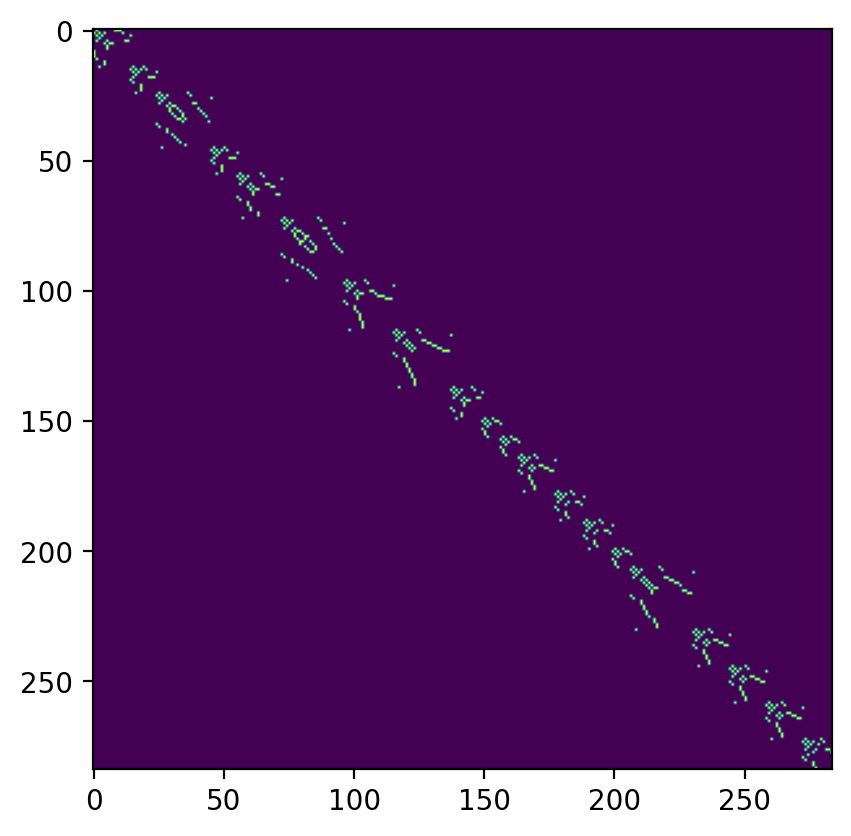

In [42]:
plt.imshow(V(prot.adjacency_matrix))

In [537]:
# to initialize random positions, we can 
# estimate the average volume occupied by each atom
# when the atoms are in a regular grid with
# the same distance between them. 
# we set this distance to 1.5A (average bond length)

# the volume occupied by each atom is a sphere with radius 1.5A
r0 = 0.15 # nm
v0 = 4/3*np.pi*r0**3
# total volume occupied by all atoms
vn = len(prot.node_positions)*v0
init_radius = (vn*3/4/np.pi)**(1/3)
init_radius


0.9859707677163644

In [538]:
# MIN_DELTA = 1e-2
# PATIENCE = 20
# DEVICE = 'cuda'

In [539]:
energy.LJ_epsilon

tensor([[0.0000, 0.5706, 0.5059,  ..., 0.2162, 0.2162, 0.0000],
        [0.5706, 0.0000, 0.4058,  ..., 0.1734, 0.1734, 0.0000],
        [0.5059, 0.4058, 0.0000,  ..., 0.1537, 0.1537, 0.0000],
        ...,
        [0.2162, 0.1734, 0.1537,  ..., 0.0000, 0.0657, 0.0000],
        [0.2162, 0.1734, 0.1537,  ..., 0.0657, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [1036]:
from coarsegrainer.GNN import GNNReparam

# hidden dimension
h = 100 #300
A = prot.adjacency_matrix.to(DEVICE) + 0*energy.LJ_epsilon.to(DEVICE) + 0.2*torch.eye(len(A)).to(DEVICE)
# A = energy.LJ_epsilon.to(DEVICE)
# degree matrix
degs = torch.sum(A, dim=1)+1e-3
D_inv = torch.diag(1/degs)
# degree normalized adjacency matrix
# A =  D_inv**(1/2) @ A @ D_inv**(1/2) #+ 0.*torch.eye(len(A)).to(DEVICE)

n = len(A)
d = 3
init_scaling = .2 #.2 #6 #1.5
gnn_reparam = GNNReparam([h, h//1, h//1, d], A=A,
                        bias=True, 
                        # activation=torch.nn.LeakyReLU() ,
                        activation=torch.nn.Tanh(), 
                        output_init_sigma= init_scaling*init_radius, 
                        device=DEVICE, residual=True)
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

gnn_minimizer = GNNMinimizer(energy, initial_pos, gnn_reparam, optimizer_type='Adam',
    lr=LR*1e-1, lr_gnn=LR*2e-2,
    # lr=LR*5e-3, lr_gnn=LR*5e-3,
    # lr=4e-4, lr_gnn=1e-4,
    # lr=4e-3, lr_gnn=1e-4,
    # lr=1e-3, lr_gnn=1e-3,
    # lr=2*LR, lr_gnn=4e-3,
    clamp_grads=1e-2, log_step=20, log_pos_step=0, 
    log_dir='../results/logs', log_name=f'GNN_protein_{pdb_id}_',
    patience=PATIENCE, min_delta=MIN_DELTA*1e-0, 
    gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e0)


std after rescaling 0.197
Using Adam optimizer
Log name: GNN_protein_2JOF_
Logging to: ../results/logs/GNN_protein_2JOF__n284_d3
Using Adam optimizer


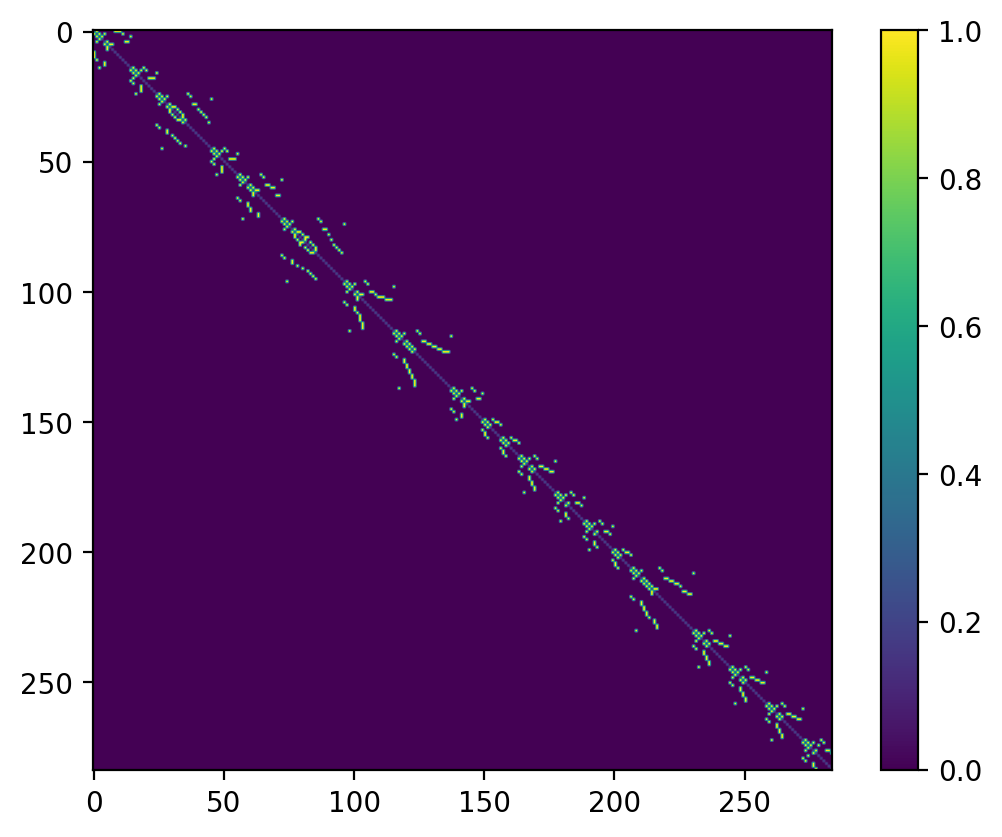

In [1037]:
plt.imshow(V(A))
plt.colorbar()

In [1038]:
(gnn_reparam().std(), gnn_minimizer.get_x().std())

(tensor(0.1972, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.1972, device='cuda:0', grad_fn=<StdBackward0>))

In [1039]:
N = 100
drop_rate = 50 #40 #10
annealer_gnn = AnnealingLR(gnn_minimizer.optimizer_gnn, 
                    lr_max=gnn_minimizer.lr_gnn, 
                    lr_min=gnn_minimizer.lr_gnn/drop_rate, 
                    epochs=N)

annealer_fg = AnnealingLR(gnn_minimizer.optimizer_fg, 
                    lr_max=gnn_minimizer.lr, 
                    lr_min=gnn_minimizer.lr/drop_rate, 
                    epochs=N)

In [1040]:
# gnn_minimizer.min_delta /= 10

In [1041]:
# annealer_fg.epochs = 200

In [1042]:
# set the learning rate of optimizer_fg to 1e-3
# gnn_minimizer.optimizer_fg.param_groups[0]['lr'] = 1e-3  

In [1043]:
relax_counter = 10
for epoch in range(2*N):
    h = gnn_minimizer.train(500)
    # also print the current lr
    
    c = gnn_minimizer.early_stop.patience_counter
    en = h["energy"][-1]
    if np.isnan(en):
        print('============Failed! Energy is nan============')
        break
    print(f'epoch: {epoch}, energy: {en:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    
    if not gnn_minimizer.fine_grained:
        annealer_gnn.step()
        print(f'GNN lr: {annealer_gnn.get_last_lr()[0]:.2e}', end = '\r')
    else:
        annealer_fg.step()
        print(f'FG lr: {annealer_fg.get_last_lr()[0]:.2e}', end = '\r')
        
    if gnn_minimizer.early_stopping_triggered:
        
        print('\n')
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

KeyboardInterrupt: 

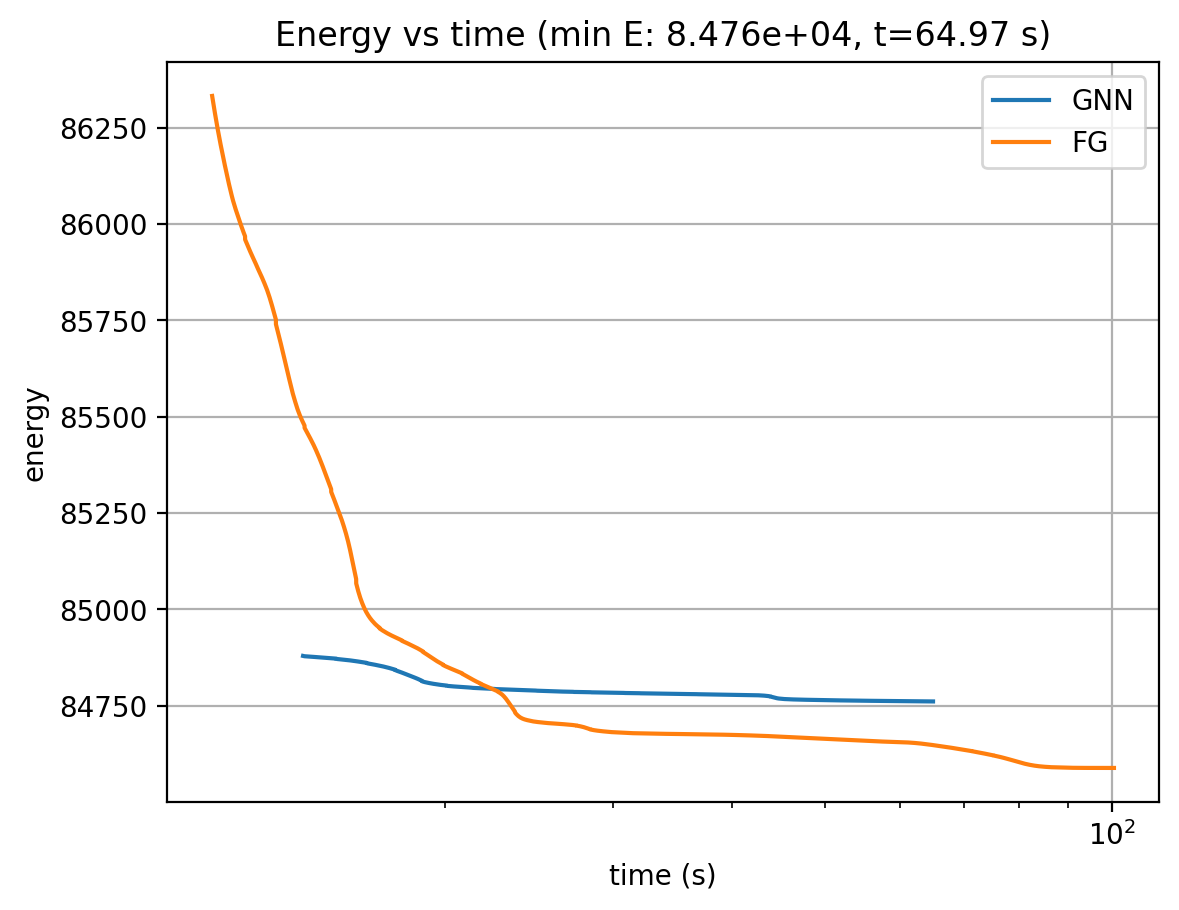

In [1045]:
k = 300
gnn_minimizer.plot_history(start=k)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

energy_minimizer.plot_history(k)
# plt.ylim(h['energy'][-1]-10, h['energy'][k]+1.0)
plt.yscale('linear')
plt.grid(True)
plt.legend(['GNN', 'FG', 'GD'])

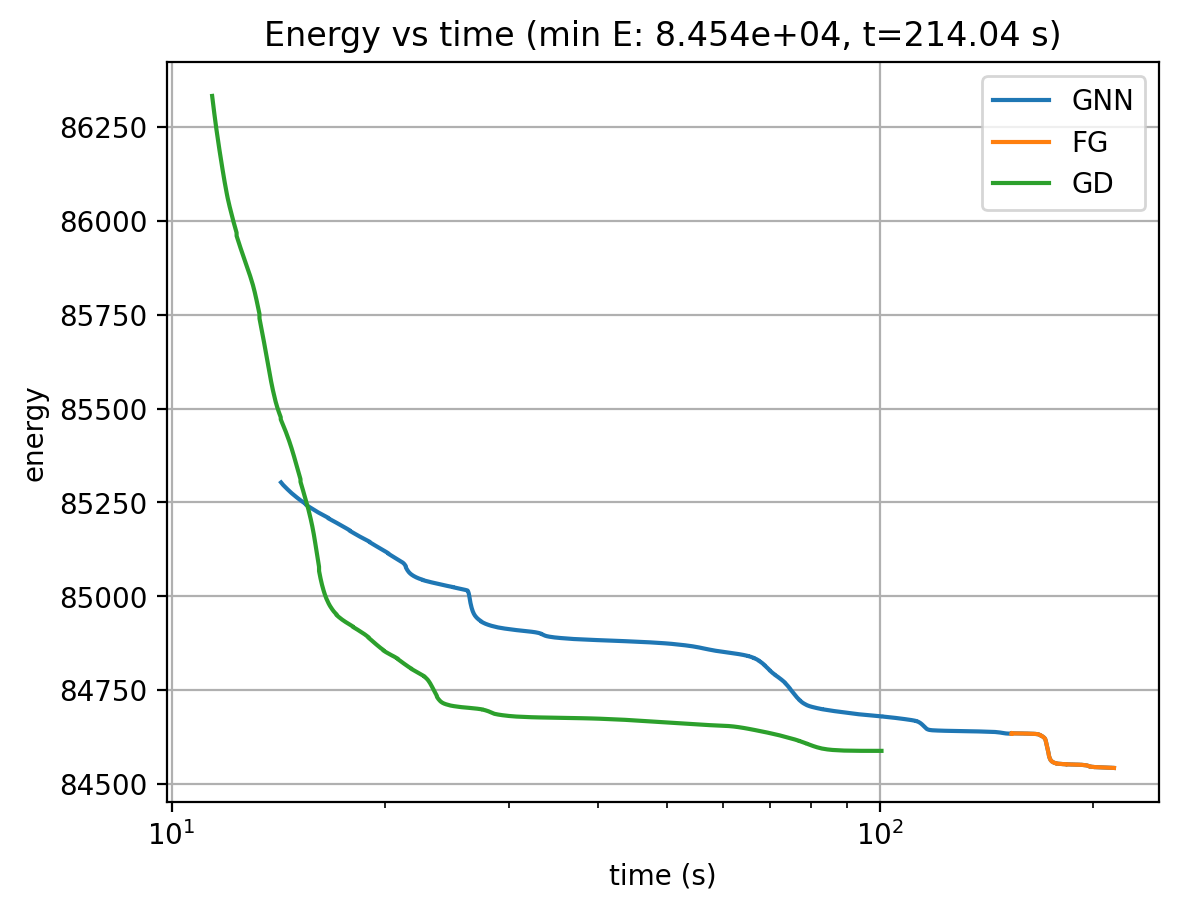

In [929]:
k = 300
gnn_minimizer.plot_history(start=k)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

energy_minimizer.plot_history(k)
# plt.ylim(h['energy'][-1]-10, h['energy'][k]+1.0)
plt.yscale('linear')
plt.grid(True)
plt.legend(['GNN', 'FG', 'GD'])

In [1]:
plt

NameError: name 'plt' is not defined

In [2]:
1

1

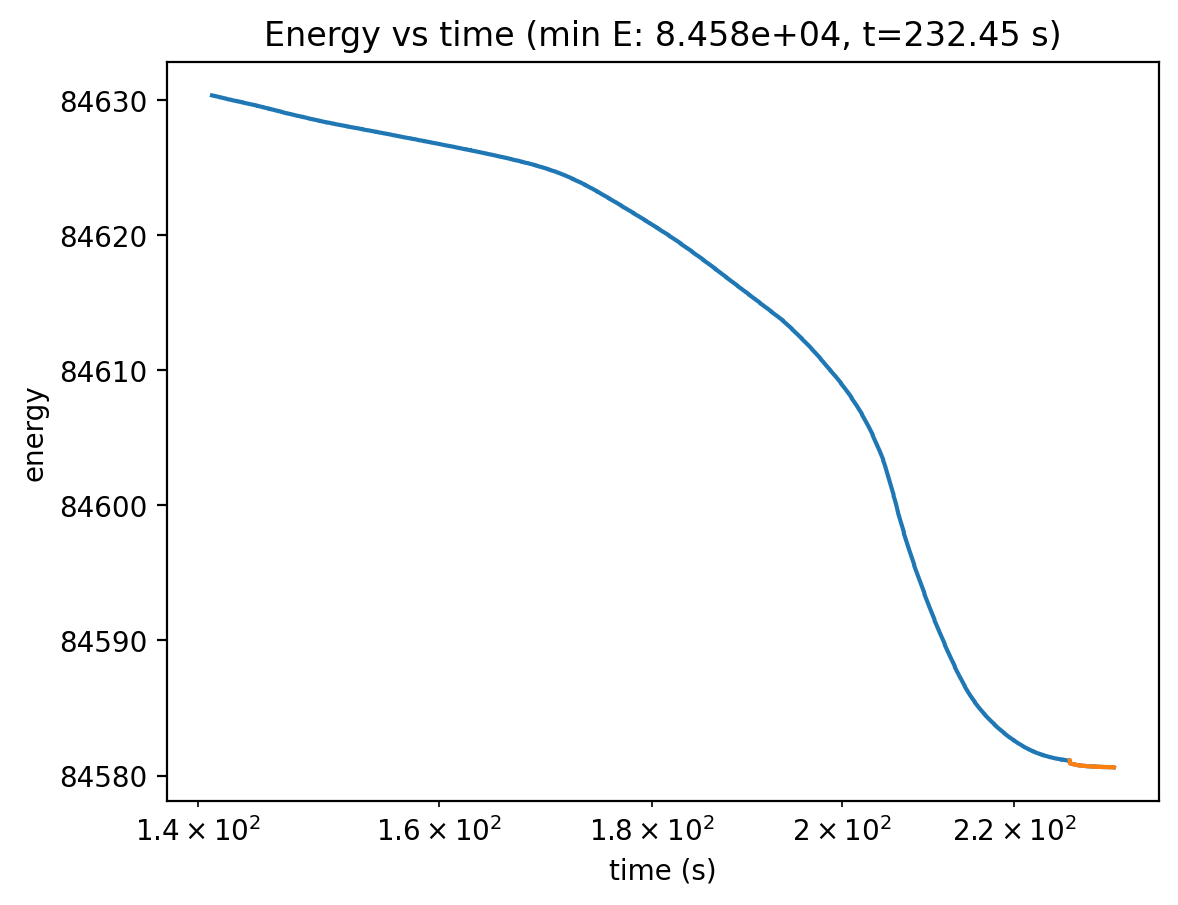

In [310]:
gnn_minimizer.plot_history(start=3000)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')
plt.yscale('linear')


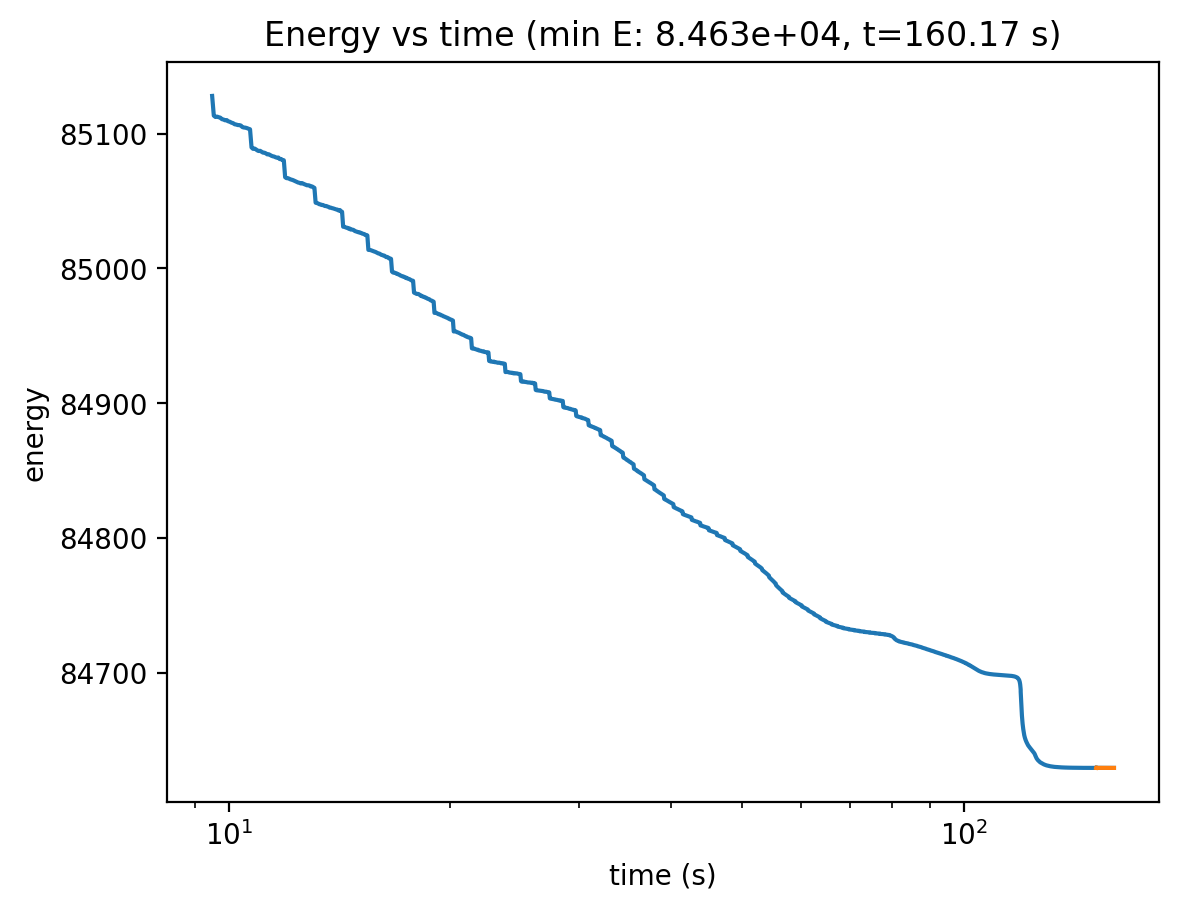

In [142]:
gnn_minimizer.plot_history(start=200)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')
plt.yscale('linear')


### get X

In [1046]:
xf = gnn_minimizer.get_x()
xf.std(dim=0)

tensor([0.3937, 0.4534, 0.4463], device='cuda:0', grad_fn=<StdBackward0>)

In [1047]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./GNN-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [1048]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### RMSD

In [1050]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 7.870340709263637, 'CA': 6.460922992030665, 'backbone': 6.4283375684739585}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [427]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 7.1047512306186755, 'CA': 5.106547918283247, 'backbone': 4.835712530836844}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [314]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 7.0849376684520715, 'CA': 5.230195636810169, 'backbone': 4.987930363069281}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [100]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 7.440000581374548, 'CA': 6.19042277841242, 'backbone': 5.978464021446474}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [267]:
import py3Dmol

# let's pick the pdb id of a small protein with two alpha helices:
# pdb_id = '2JOF' #  '1HLO'
# pdb_dir = '../data/pdb/'
# os.makedirs(pdb_dir, exist_ok=True) 
# pf.download_pdb_file(pdb_id, dir = pdb_dir)
# pdb_test_file = os.path.join(pdb_dir, pdb_id+'.pdb')

p_ = py3Dmol.view(data=pf.get_file_text(pdb_orig_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.